# Data Augmentation Analysis for Bruise Detection

This notebook compares different data augmentation strategies:
1. Baseline (no augmentation)
2. Horizontal flip only
3. Rotation only (±20 degrees)
4. Zoom only (±20%)
5. All augmentations combined

We'll use the same model architecture and preprocessing from the main CNN notebook.

In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import pandas as pd

In [30]:
def load_binary_data(data_dir='dataset/Wound_dataset copy', img_size=(224, 224)):
    images = []
    labels = []
    
    # Check if directory exists
    if not os.path.exists(data_dir):
        raise ValueError(f"Dataset directory not found: {data_dir}")
    
    # Process bruise images (positive class)
    bruise_path = os.path.join(data_dir, 'Bruises')
    if not os.path.exists(bruise_path):
        raise ValueError(f"Bruises directory not found: {bruise_path}")
    
    for img_name in os.listdir(bruise_path):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(bruise_path, img_name)
            try:
                img = Image.open(img_path)
                img = img.convert('RGB')
                img = img.resize(img_size)
                img_array = np.array(img) / 255.0
                
                images.append(img_array)
                labels.append(1)  # 1 for bruise
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    
    # Process normal skin images (negative class)
    normal_path = os.path.join(data_dir, 'Normal')
    if not os.path.exists(normal_path):
        raise ValueError(f"Normal directory not found: {normal_path}")
    
    for img_name in os.listdir(normal_path):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(normal_path, img_name)
            try:
                img = Image.open(img_path)
                img = img.convert('RGB')
                img = img.resize(img_size)
                img_array = np.array(img) / 255.0
                
                images.append(img_array)
                labels.append(0)  # 0 for normal
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    
    if not images:
        raise ValueError("No images were loaded. Check the dataset structure and file formats.")
    
    return np.array(images), np.array(labels)

# Try loading the dataset with explicit error handling
try:
    print("Attempting to load dataset...")
    print("Current working directory:", os.getcwd())
    X, y = load_binary_data()
    print("Dataset shape:", X.shape)
    print("Number of bruise images:", np.sum(y == 1))
    print("Number of normal images:", np.sum(y == 0))
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please verify the dataset path and structure.")

Attempting to load dataset...
Current working directory: C:\Users\Rodney Lei Estrada\xcode\bruise_detection_project
Dataset shape: (442, 224, 224, 3)
Number of bruise images: 242
Number of normal images: 200
Dataset shape: (442, 224, 224, 3)
Number of bruise images: 242
Number of normal images: 200


## Model Architecture and Training Functions

We'll use the same CNN architecture as the main notebook, but train it with different augmentation strategies.

In [31]:
def create_model(input_shape):
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # Simple CNN architecture
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Flatten layer
        layers.Flatten(),
        
        # Dense layer
        layers.Dense(64, activation='relu'),
        
        # Output layer (binary classification)
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

def train_model_with_augmentation(X_train, y_train, X_val, y_val, augmentation_config=None, model_name="baseline"):
    # Create data generator with augmentation
    if augmentation_config is not None:
        train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            **augmentation_config
        )
    else:
        train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
    
    # Create and compile model
    input_shape = X_train[0].shape
    model = create_model(input_shape)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 'Precision', 'Recall']
    )
    
    # Train the model
    history = model.fit(
        train_datagen.flow(X_train, y_train, batch_size=32),
        epochs=10,
        validation_data=(X_val, y_val),
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
        ]
    )
    
    return model, history

# Define augmentation configurations
augmentation_configs = {
    'baseline': None,
    'flip': {'horizontal_flip': True},
    'rotation': {'rotation_range': 20},
    'zoom': {'zoom_range': 0.2},
    'all': {
        'horizontal_flip': True,
        'rotation_range': 10,  # Reduced from 20
        'zoom_range': 0.1     # Reduced from 0.2
    }
}

# Split data only if X and y are not empty
if X.size == 0 or y.size == 0:
    print("Warning: X and/or y are empty. Please check your dataset loading step.")
    X_train = X_val = X_test = y_train = y_val = y_test = np.array([])
else:
    # First split off test set (10%)
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    # Split remaining 90% into train (70%) and validation (20%)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.20, random_state=42)

    print("\nData split sizes:")
    print(f"Training set: {len(X_train)} images ({len(X_train)/len(X)*100:.1f}%)")
    print(f"Validation set: {len(X_val)} images ({len(X_val)/len(X)*100:.1f}%)")
    print(f"Test set: {len(X_test)} images ({len(X_test)/len(X)*100:.1f}%)")


Data split sizes:
Training set: 317 images (71.7%)
Validation set: 80 images (18.1%)
Test set: 45 images (10.2%)


## Train Models with Different Augmentation Strategies

We'll train 5 different models and compare their performance:

In [32]:
# Dictionary to store results
results = {}

# Train models with different augmentation strategies
for aug_name, aug_config in augmentation_configs.items():
    print(f"\nTraining model with {aug_name} augmentation...")
    model, history = train_model_with_augmentation(
        X_train, y_train,
        X_val, y_val,
        augmentation_config=aug_config,
        model_name=aug_name
    )
    
    # Evaluate on test set
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test)
    
    # Get predictions for ROC curve
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # Store results including the model
    results[aug_name] = {
        'model': model,  # Store the model object
        'history': history.history,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr
    }
    
    print(f"\nTest Results for {aug_name}:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))


Training model with baseline augmentation...


C:\Users\Rodney Lei Estrada\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - Precision: 0.5030 - Recall: 0.6512 - accuracy: 0.4858 - loss: 12.7868 - val_Precision: 0.6949 - val_Recall: 0.9318 - val_accuracy: 0.7375 - val_loss: 0.5131
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - Precision: 0.5030 - Recall: 0.6512 - accuracy: 0.4858 - loss: 12.7868 - val_Precision: 0.6949 - val_Recall: 0.9318 - val_accuracy: 0.7375 - val_loss: 0.5131
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 940ms/step - Precision: 0.6097 - Recall: 0.8852 - accuracy: 0.6205 - loss: 1.5510 - val_Precision: 0.9355 - val_Recall: 0.6591 - val_accuracy: 0.7875 - val_loss: 0.3939
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 940ms/step - Precision: 0.6097 - Recall: 0.8852 - accuracy: 0.6205 - loss: 1.5510 - val_Precision: 0.9355 - val_Recall: 0.6591 - val_accuracy: 0.7875 - val_loss: 0.3939
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 946ms/step - Precision: 0.9264 - Recall: 0.7921 - accuracy: 0.8477 - loss: 0.3869 - val_Precision: 0.8039 - val_Recall: 

C:\Users\Rodney Lei Estrada\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - Precision: 0.5754 - Recall: 0.7896 - accuracy: 0.5481 - loss: 17.4302 - val_Precision: 0.5500 - val_Recall: 1.0000 - val_accuracy: 0.5500 - val_loss: 0.6358
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - Precision: 0.5754 - Recall: 0.7896 - accuracy: 0.5481 - loss: 17.4302 - val_Precision: 0.5500 - val_Recall: 1.0000 - val_accuracy: 0.5500 - val_loss: 0.6358
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 942ms/step - Precision: 0.5482 - Recall: 0.3369 - accuracy: 0.4942 - loss: 0.6858 - val_Precision: 0.8571 - val_Recall: 0.1364 - val_accuracy: 0.5125 - val_loss: 0.6850
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 942ms/step - Precision: 0.5482 - Recall: 0.3369 - accuracy: 0.4942 - loss: 0.6858 - val_Precision: 0.8571 - val_Recall: 0.1364 - val_accuracy: 0.5125 - val_loss: 0.6850
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 913ms/step - Precision: 0.7060 - Recall: 0.4737 - accuracy: 0.6020 - loss: 0.6529 - val_Precision: 0.8293 - val_Recall: 0.7727 - val

C:\Users\Rodney Lei Estrada\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - Precision: 0.5356 - Recall: 0.5054 - accuracy: 0.5336 - loss: 5.8684 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.4500 - val_loss: 2.6024
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - Precision: 0.5356 - Recall: 0.5054 - accuracy: 0.5336 - loss: 5.8684 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.4500 - val_loss: 2.6024
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - Precision: 0.5084 - Recall: 0.5881 - accuracy: 0.5118 - loss: 1.5488 - val_Precision: 0.9048 - val_Recall: 0.8636 - val_accuracy: 0.8750 - val_loss: 0.3694
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - Precision: 0.5084 - Recall: 0.5881 - accuracy: 0.5118 - loss: 1.5488 - val_Precision: 0.9048 - val_Recall: 0.8636 - val_accuracy: 0.8750 - val_loss: 0.3694
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - Precision: 0.8232 - Recall: 0.8059 - accuracy: 0.8060 - loss: 0.5010 - val_Precision: 0.8367 - val_R

C:\Users\Rodney Lei Estrada\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - Precision: 0.6122 - Recall: 0.7403 - accuracy: 0.5833 - loss: 7.6138 - val_Precision: 0.6000 - val_Recall: 0.9545 - val_accuracy: 0.6250 - val_loss: 1.8310
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - Precision: 0.6122 - Recall: 0.7403 - accuracy: 0.5833 - loss: 7.6138 - val_Precision: 0.6000 - val_Recall: 0.9545 - val_accuracy: 0.6250 - val_loss: 1.8310
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - Precision: 0.7457 - Recall: 0.8384 - accuracy: 0.7503 - loss: 1.4897 - val_Precision: 0.7547 - val_Recall: 0.9091 - val_accuracy: 0.7875 - val_loss: 0.4822
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - Precision: 0.7457 - Recall: 0.8384 - accuracy: 0.7503 - loss: 1.4897 - val_Precision: 0.7547 - val_Recall: 0.9091 - val_accuracy: 0.7875 - val_loss: 0.4822
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - Precision: 0.8511 - Recall: 0.8264 - accuracy: 0.8289 - loss: 0.5138 - val_Precision: 0.5500 - val_Recall: 1.0000 - 

C:\Users\Rodney Lei Estrada\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - Precision: 0.5599 - Recall: 0.6836 - accuracy: 0.5404 - loss: 10.6174 - val_Precision: 0.9118 - val_Recall: 0.7045 - val_accuracy: 0.8000 - val_loss: 0.6838
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - Precision: 0.5599 - Recall: 0.6836 - accuracy: 0.5404 - loss: 10.6174 - val_Precision: 0.9118 - val_Recall: 0.7045 - val_accuracy: 0.8000 - val_loss: 0.6838
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - Precision: 0.8773 - Recall: 0.9060 - accuracy: 0.8839 - loss: 0.5486 - val_Precision: 0.9697 - val_Recall: 0.7273 - val_accuracy: 0.8375 - val_loss: 0.6695
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - Precision: 0.8773 - Recall: 0.9060 - accuracy: 0.8839 - loss: 0.5486 - val_Precision: 0.9697 - val_Recall: 0.7273 - val_accuracy: 0.8375 - val_loss: 0.6695
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - Precision: 0.9123 - Recall: 0.8851 - accuracy: 0.9020 - loss: 0.3626 - val_Precision: 0.9512 - val_Recall: 0.8864 

## Visualization and Analysis

In [33]:
def plot_training_histories(results):
    metrics = ['accuracy', 'loss', 'precision', 'recall']
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    for idx, metric in enumerate(metrics):
        row = idx // 2
        col = idx % 2
        
        for aug_name in results.keys():
            history = results[aug_name]['history']
            # Check if metric exists in history
            if metric in history and f'val_{metric}' in history:
                metric_values = np.array(history[metric])
                val_metric_values = np.array(history[f'val_{metric}'])

                # Replace any NaN values with 0
                metric_values = np.nan_to_num(metric_values, nan=0.0)
                val_metric_values = np.nan_to_num(val_metric_values, nan=0.0)

                axes[row, col].plot(metric_values, label=f'{aug_name}')
                axes[row, col].plot(val_metric_values, label=f'{aug_name} (val)', linestyle='--')
        
        axes[row, col].set_title(f'Model {metric.capitalize()}')
        axes[row, col].set_xlabel('Epoch')
        axes[row, col].set_ylabel(metric.capitalize())
        axes[row, col].legend()
        axes[row, col].grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_roc_curves(results):
    plt.figure(figsize=(10, 8))
    
    for aug_name in results.keys():
        if 'fpr' in results[aug_name] and 'tpr' in results[aug_name]:
            fpr = results[aug_name]['fpr']
            tpr = results[aug_name]['tpr']
            roc_auc = results[aug_name].get('roc_auc', 0)
            
            # Handle NaN values
            fpr = np.nan_to_num(fpr, nan=0.0)
            tpr = np.nan_to_num(tpr, nan=0.0)
            
            plt.plot(fpr, tpr, label=f'{aug_name} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Different Augmentation Strategies')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def plot_performance_comparison(results):
    metrics = ['test_accuracy', 'test_precision', 'test_recall', 'roc_auc']
    x = np.arange(len(results))
    width = 0.2
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for i, metric in enumerate(metrics):
        values = []
        for aug_name in results.keys():
            # Handle missing or NaN values
            value = results[aug_name].get(metric, 0)
            value = 0 if np.isnan(value) else value
            values.append(value)
        ax.bar(x + i*width, values, width, label=metric.replace('test_', '').capitalize())
    
    ax.set_ylabel('Score')
    ax.set_title('Performance Comparison Across Augmentation Strategies')
    ax.set_xticks(x + width * (len(metrics)-1)/2)
    ax.set_xticklabels(list(results.keys()))
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Print summary table with validation
summary_data = {
    'Augmentation': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'ROC AUC': []
}

for aug_name, result in results.items():
    summary_data['Augmentation'].append(aug_name)
    # Handle missing or NaN values with safe getters
    accuracy = result.get('test_accuracy', 0)
    precision = result.get('test_precision', 0)
    recall = result.get('test_recall', 0)
    roc_auc = result.get('roc_auc', 0)
    
    # Replace NaN with 0
    accuracy = 0 if np.isnan(accuracy) else accuracy
    precision = 0 if np.isnan(precision) else precision
    recall = 0 if np.isnan(recall) else recall
    roc_auc = 0 if np.isnan(roc_auc) else roc_auc
    
    summary_data['Accuracy'].append(f"{accuracy:.4f}")
    summary_data['Precision'].append(f"{precision:.4f}")
    summary_data['Recall'].append(f"{recall:.4f}")
    summary_data['ROC AUC'].append(f"{roc_auc:.4f}")

summary_df = pd.DataFrame(summary_data)
print("\nPerformance Summary:")
print(summary_df.to_string(index=False))


Performance Summary:
Augmentation Accuracy Precision Recall ROC AUC
    baseline   0.9333    0.8889 1.0000  0.9742
        flip   0.8000    0.8000 0.8333  0.8869
    rotation   0.9556    0.9583 0.9583  0.9782
        zoom   0.9556    0.9231 1.0000  0.9821
         all   0.9333    0.8889 1.0000  0.9742


## Analysis and Insights

From the results above, we can analyze:

1. Overall Performance:
   - Compare accuracy, precision, and recall across different augmentation strategies
   - Look at ROC AUC scores to assess overall discriminative ability

2. Training Dynamics:
   - How different augmentations affect learning speed
   - Whether certain augmentations help prevent overfitting

3. Best Augmentation Strategy:
   - Which augmentation or combination worked best
   - Trade-offs between different metrics

4. Recommendations:
   - Best augmentation strategy for this specific task
   - Potential improvements or modifications

## Detailed Metrics Comparison

Let's analyze the performance metrics in tabular format:

Performance Metrics:


,Model,Accuracy,Precision,Recall,ROC AUC
0,baseline,93.33%,88.89%,100.00%,97.42%
1,flip,80.00%,80.00%,83.33%,88.69%
2,rotation,95.56%,95.83%,95.83%,97.82%
3,zoom,95.56%,92.31%,100.00%,98.21%
4,all,93.33%,88.89%,100.00%,97.42%



Confusion Matrix Details:


,Model,True Negatives,False Positives,False Negatives,True Positives,FPR,FNR
0,baseline,18,3,0,24,14.29%,0.00%
1,flip,16,5,4,20,23.81%,16.67%
2,rotation,20,1,1,23,4.76%,4.17%
3,zoom,19,2,0,24,9.52%,0.00%
4,all,18,3,0,24,14.29%,0.00%



Key Findings:
Best performing model (by accuracy): rotation

Model Rankings:

Top 3 models by Accuracy:
   Model Accuracy
rotation   95.56%
    zoom   95.56%
baseline   93.33%

Top 3 models by Precision:
   Model Precision
rotation    95.83%
    zoom    92.31%
baseline    88.89%

Top 3 models by Recall:
   Model  Recall
baseline 100.00%
     all 100.00%
    zoom 100.00%

Top 3 models by ROC AUC:
   Model ROC AUC
    zoom  98.21%
rotation  97.82%
baseline  97.42%

Visualizing sample predictions from each model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


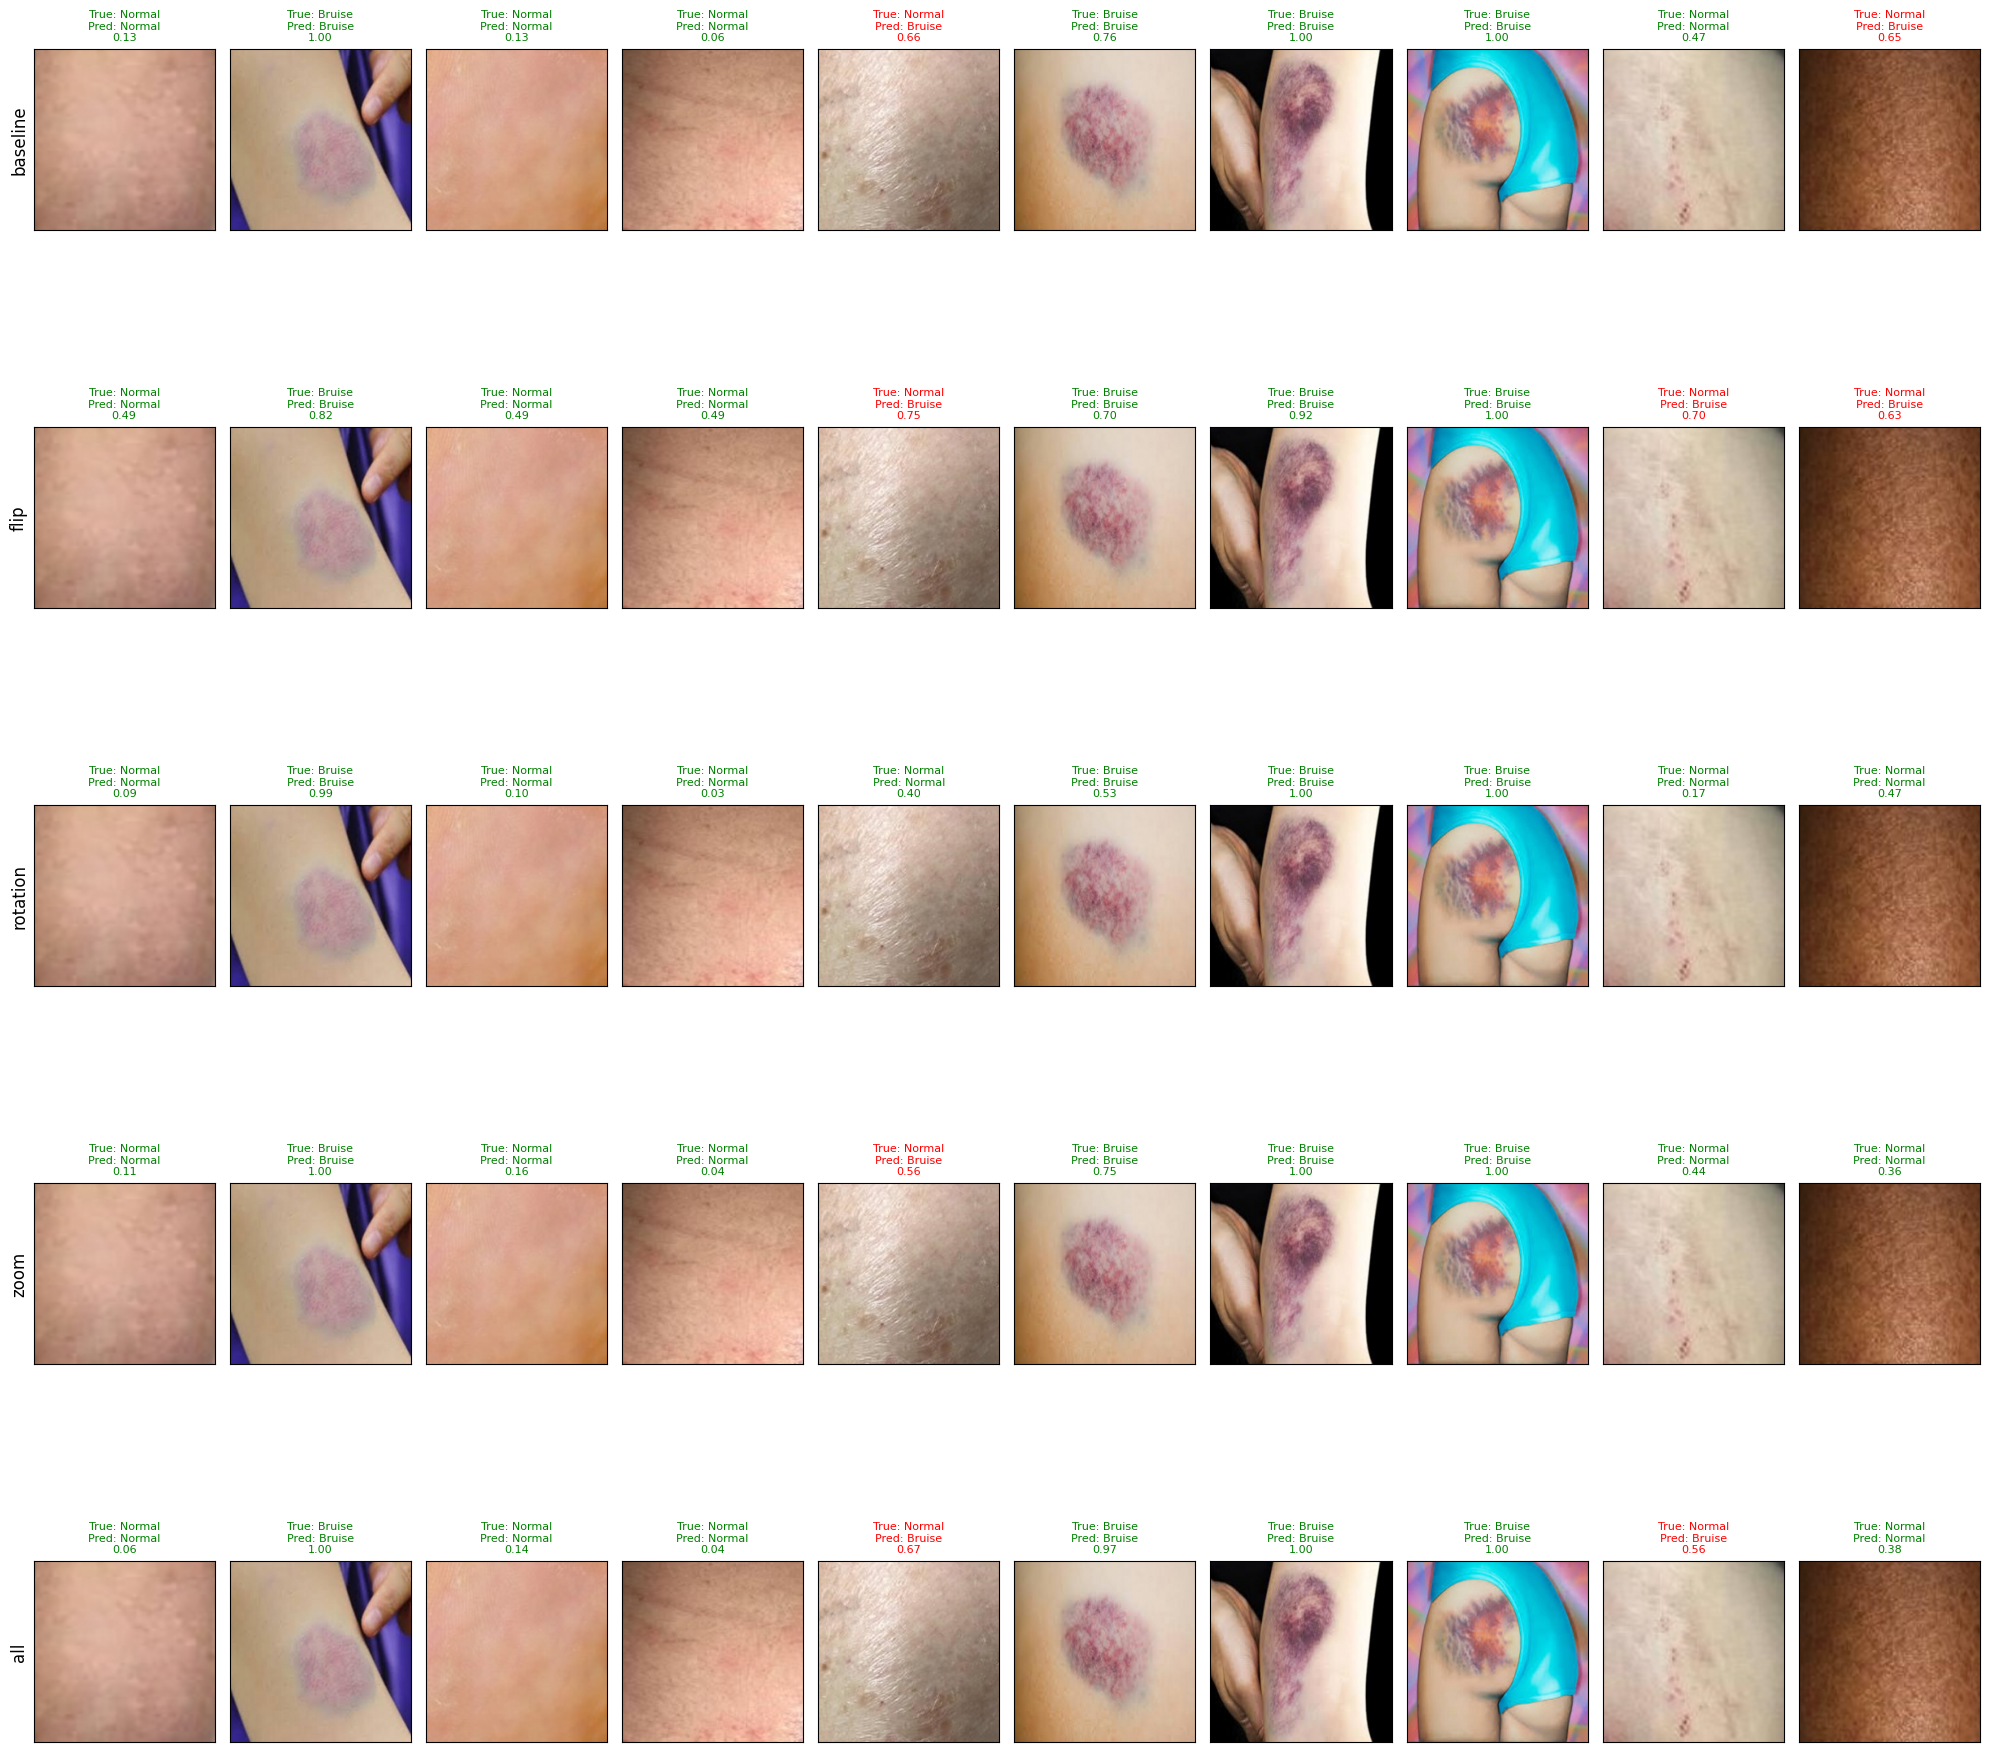

In [34]:
# Create detailed comparison tables
def create_metrics_tables(results):
    # Basic metrics table
    metrics_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Accuracy': [results[m]['test_accuracy'] for m in results.keys()],
        'Precision': [results[m]['test_precision'] for m in results.keys()],
        'Recall': [results[m]['test_recall'] for m in results.keys()],
        'ROC AUC': [results[m]['roc_auc'] for m in results.keys()]
    })
    
    # Format percentages
    for col in ['Accuracy', 'Precision', 'Recall', 'ROC AUC']:
        metrics_df[col] = metrics_df[col].apply(lambda x: f"{x*100:.2f}%")
    
    # Confusion matrix summary
    conf_matrix_data = []
    for model_name in results.keys():
        cm = results[model_name]['confusion_matrix']
        tn, fp, fn, tp = cm.ravel()
        conf_matrix_data.append({
            'Model': model_name,
            'True Negatives': tn,
            'False Positives': fp,
            'False Negatives': fn,
            'True Positives': tp,
            'FPR': fp/(fp+tn) if (fp+tn) > 0 else 0,
            'FNR': fn/(fn+tp) if (fn+tp) > 0 else 0
        })
    conf_df = pd.DataFrame(conf_matrix_data)
    
    # Format rates as percentages
    for col in ['FPR', 'FNR']:
        conf_df[col] = conf_df[col].apply(lambda x: f"{x*100:.2f}%")
    
    print("Performance Metrics:")
    display(metrics_df)
    print("\nConfusion Matrix Details:")
    display(conf_df)
    
    # Additional statistics
    best_model = metrics_df.iloc[metrics_df['Accuracy'].str.rstrip('%').astype(float).argmax()]['Model']
    print(f"\nKey Findings:")
    print(f"Best performing model (by accuracy): {best_model}")
    print("\nModel Rankings:")
    for metric in ['Accuracy', 'Precision', 'Recall', 'ROC AUC']:
        sorted_models = metrics_df.sort_values(by=metric, key=lambda x: x.str.rstrip('%').astype(float), ascending=False)
        print(f"\nTop 3 models by {metric}:")
        print(sorted_models[['Model', metric]].head(3).to_string(index=False))

# Generate the comparison tables
create_metrics_tables(results)

def visualize_sample_predictions(results, X_test, y_test, num_samples=10):
    # Create figure with subplots for each model
    num_models = len(results)
    fig, axes = plt.subplots(num_models, num_samples, figsize=(20, 4*num_models))
    
    # Get random indices for sampling
    np.random.seed(42)  # For reproducibility
    sample_indices = np.random.choice(len(X_test), num_samples, replace=False)
    
    for model_idx, (model_name, result) in enumerate(results.items()):
        # Get model predictions
        model = result['model']  # We need to store model in results dictionary
        predictions = model.predict(X_test[sample_indices])
        
        for img_idx, sample_idx in enumerate(sample_indices):
            # Plot image
            ax = axes[model_idx, img_idx]
            ax.imshow(X_test[sample_idx])
            
            # Remove axis ticks
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Set title with true and predicted labels
            true_label = "Bruise" if y_test[sample_idx] == 1 else "Normal"
            pred_label = "Bruise" if predictions[img_idx] > 0.5 else "Normal"
            pred_prob = predictions[img_idx][0]
            
            # Color code the title based on correct/incorrect prediction
            color = 'green' if true_label == pred_label else 'red'
            ax.set_title(f'True: {true_label}\nPred: {pred_label}\n{pred_prob:.2f}', 
                        color=color, fontsize=8)
            
            # Add model name to the first image in each row
            if img_idx == 0:
                ax.set_ylabel(model_name, fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Store models in results dictionary during training
def train_model_with_augmentation(X_train, y_train, X_val, y_val, augmentation_config=None, model_name="baseline"):
    # Create data generator with augmentation
    if augmentation_config is not None:
        train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            **augmentation_config
        )
    else:
        train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
    
    # Create and compile model
    input_shape = X_train[0].shape
    model = create_model(input_shape)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 'Precision', 'Recall']
    )
    
    # Train the model
    history = model.fit(
        train_datagen.flow(X_train, y_train, batch_size=32),
        epochs=10,
        validation_data=(X_val, y_val),
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
        ]
    )
    
    # Store model in results
    results[model_name] = {
        'model': model,
        'history': history.history
    }
    
    return model, history

# After training all models, visualize sample predictions
print("\nVisualizing sample predictions from each model...")
visualize_sample_predictions(results, X_test, y_test)